In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if 'module_path' not in sys.path:
    sys.path.append(module_path)

import numpy as np
import nibabel as nib
import neurolang as nl
from typing import AbstractSet, Callable
from neurolang.regions import *
from neurolang.region_solver import *
from neurolang.symbols_and_types import TypedSymbolTable

%matplotlib inline

### Load a subject's brain imaging data:

In [4]:
subject = '100206'
t1w_path = '../data/%s/T1w/T1w_acpc_dc_restore_brain.nii.gz' % subject
labels_path = '../data/%s/T1w/aparc.a2009s+aseg.nii.gz' % subject
labeled_im = nib.load(labels_path)
t1w_im = nib.load(t1w_path)
type(labeled_im)

nibabel.nifti1.Nifti1Image

### Basic plotting of the subject data:

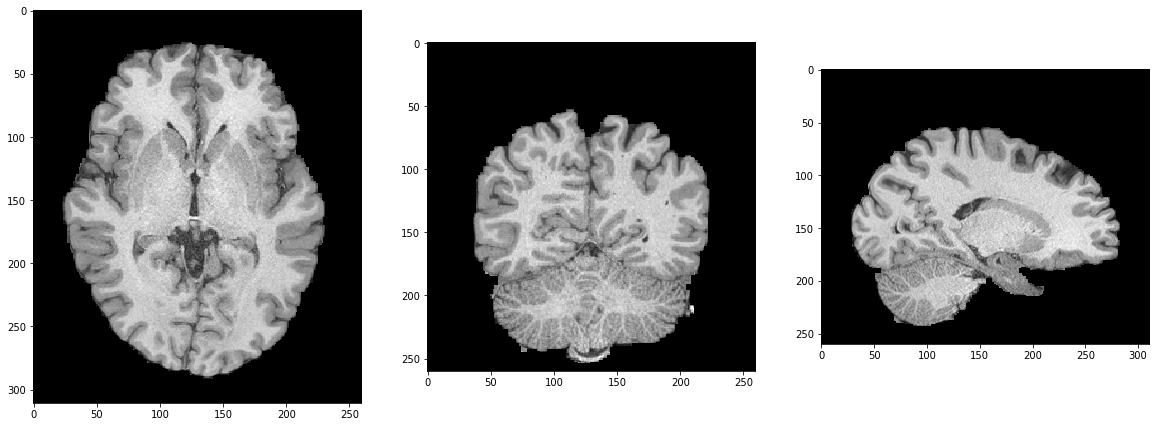

In [20]:
import matplotlib.pyplot as plt
img_data = t1w_im.get_data()

fig = plt.figure(figsize = (20, 20)) 
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(img_data[:,:,100]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(img_data[:,100,:]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(img_data[100,:,:]),cmap = plt.cm.gray,interpolation = 'nearest')

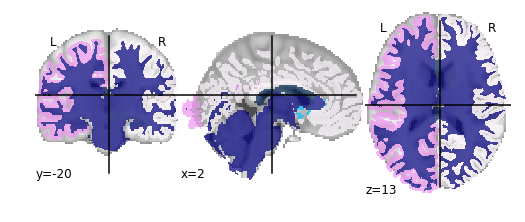

In [3]:
from nilearn import plotting
plotting.plot_roi(labeled_im)

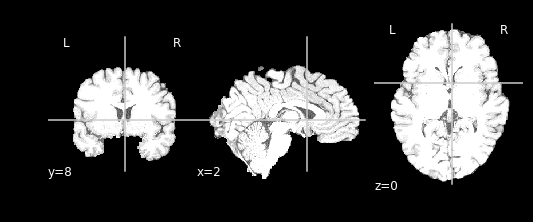

In [9]:
from nilearn.plotting import plot_anat, plot_epi, plot_roi
plot_anat(t1w_im,dim=-1)

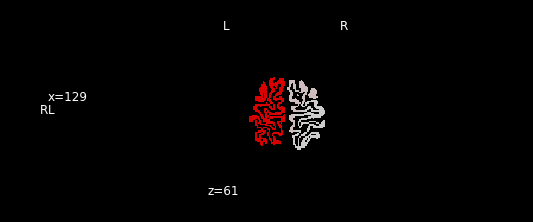

In [10]:
cut_coords = [129, 141, 61]
plot_epi(labeled_im,cut_coords=cut_coords,display_mode='ortho')

### Parse labeled regions from subject

In [18]:
from xml.etree import ElementTree
extension_header = ElementTree.fromstring(labeled_im.header.extensions[0].get_content())

labeltable = {
    l.text: int(l.get('Key'))
    for l in extension_header.findall(".//Label")
}
labels = labeled_im.get_data()

### Plot a specific region masked over the T1w image:

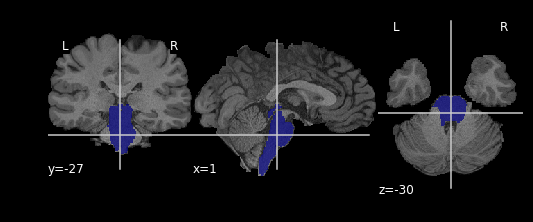

In [12]:
def plot_masked_region_from_voxels(brain_img,voxels):
    mask = np.zeros(brain_img.shape)
    for e in voxels:
        mask[tuple(map(int,e))] = 1
    img = nib.Nifti1Image(mask, brain_img.affine)
    plotting.plot_roi(img,brain_img) 

brain_stem_voxels = (labels == labeltable['BRAIN-STEM']).nonzero()

plot_masked_region_from_voxels(t1w_im, zip(*brain_stem_voxels))

### Define a specific region around a world coordinate 

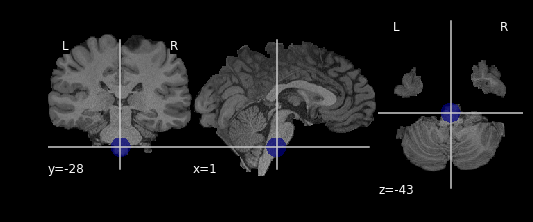

In [33]:
brain_stem_coords = nib.affines.apply_affine(labeled_im.affine, np.transpose(brain_stem_voxels))
center = brain_stem_coords[int(brain_stem_coords.shape[0] / 2)]
radius = 10
sr = SphericVolume(center, radius)
sphere_voxels = sr.to_ijk(labeled_im.affine)
plot_masked_region_from_voxels(t1w_im, sphere_voxels)

### Load labeled regions as symbols into the solver:

In [44]:
set_type = AbstractSet[Region]
solver = RegionsSetSolver(TypedSymbolTable())
solver.load_regions_symbols_from_subject_data(subject)
regions = [k.name for k, v in solver.symbol_table.symbols_by_type(set_type).items()]
len(regions)

192

### Perform a simple query over a specific region:

In [55]:
relation = 'inferior_of'
predicate = nl.Predicate[set_type](
        nl.Symbol[Callable[[set_type], set_type]](relation),
        (nl.Symbol[set_type]('BRAIN-STEM'),)
    )
query = nl.Query[set_type](nl.Symbol[set_type]('query'), predicate)

solver.walk(query)
result = solver.symbol_table['query'].value
obtained = [e for e in solver.get_label_of_regions_by_limits(result) if e.isupper()]

#pairs of (relation, region) which should return empty set:
#anterior_of CTX_RH_G_AND_S_TRANSV_FRONTOPOL
#superior_of CTX_RH_G_AND_S_PARACENTRAL
#inferior_of BRAIN-STEM

In [56]:
print(len(obtained), obtained)

0 []
